# Lab: Phân lớp

- MSSV: 22120054
- Họ và tên: Lê Văn Thành Đạt

## Yêu cầu bài tập

**Cách làm bài**


Bạn sẽ làm trực tiếp trên file notebook này; trong file, từ `TODO` để cho biết những phần mà bạn cần phải làm.

Bạn có thể thảo luận ý tưởng cũng như tham khảo các tài liệu, nhưng *code và bài làm phải là của bạn*. 

Nếu vi phạm thì sẽ bị 0 điểm cho bài tập này.

**Cách nộp bài**

Trước khi nộp bài, rerun lại notebook (`Kernel` -> `Restart & Run All`).

Sau đó, đặt tên notebook bằng `MSSV` của bạn (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên notebook là `1234567.ipynb`) và nộp ở link trên moodle.

**Nội dung bài tập**

Trong bài này, bạn sẽ cài đặt 2 thuật toán phân lớp: 
1. Cây quyết định (Decision tree)
2. Gaussian Naive Bayes

**Một số lưu ý**
1. Chỉ cần phát hiện có dấu hiện có sau chép code sẽ 0 điểm cả lab và có thể dẫn đến không điểm môn học
2. Sai format nộp bài sẽ bị trừ 20% số điểm
3. Trễ deadline 1 ngày sẽ bị trừ 40% số điểm. Sau 24h kể từ hạn nộp sẽ không nhận bất kì bài nộp bổ sung nào.
4. Các thắc mắc về bài tập, các bạn vui lòng liên hệ giáo viên qua email `ntthuhang0131@gmail.com` với tiêu đề `[Cơ sở trí tuệ nhân tạo - CQ2022/22 - Thắc mắc lab 03]`

### Thêm thư viện cần thiết

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

### Load dữ liệu Iris

In [2]:
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()

X=iris.data
y=iris.target

#split dataset into training data and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)

## 1. Cây quyết định (Decision Tree)

## 1.1 Iterative Dichotomiser 3 (ID3) (2 đ)

### 1.1.1 Information Gain

Thông tin kỳ vọng (entropy):

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

Hàm entropy đạt giá trị nhỏ nhất nếu có một giá trị $p_i=1$, đạt giá trị lớn nhất nếu tất cả các $p_i$ bằng nhau. Những tính chất này của hàm entropy khiến nó được sử dụng trong việc đo độ hỗn loạn của một phép phân chia của ID3.

In [3]:
import math


def entropy(counts, n_samples):
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples
    
    -----------
    return entropy 
    """
    #TODO
    res = 0
    for i in range(len(counts)):
        if(counts[i] != 0):
            res -= counts[i]/n_samples * math.log2(counts[i]/n_samples)
    
    return res

In [4]:
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = len(division)
    n_classes = set(division)
    
    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for classes in n_classes:
        count = 0
        for sample in division:
            if sample == classes:
                count += 1
        counts.append(count)
    
    return entropy(counts,n_samples),n_samples


def get_entropy(y_predict, y):
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = len(y)
    s_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y[~y_predict]) # right hand side entropy
    s = n_true/n * s_true + n_false/n * s_false # overall entropy
    return s

Độ lợi thông tin phân lớp tập D theo thuộc tính A:
$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

Trong ID3, tại mỗi node, thuộc tính được chọn được xác định dựa trên là thuộc tính khiến cho information gain đạt giá trị lớn nhất.

Các thuộc tính của tập Iris đều có giá trị liên tục. Do đó ta cần rời rạc hóa cho từng thuộc tính. Cách đơn giản là sử dụng một ngưỡng `cutoff` chia giá trị của dữ liệu trên mỗi thuộc tính sẽ làm 2 phần: `value<cutoff` và `value>=cutoff`.

Để tìm ngưỡng `cutoff` tốt nhất cho mỗi thuộc tính ta lần lượt thay `cutoff` bằng các giá trị của thuộc tính sau đó tính entropy, `cutoff` tốt nhất khi entropy bé nhất.  

### 1.1.2 Decision tree

In [5]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''
        
        self.depth = depth
        self.tree=tree
    def fit(self, X, y, node={}, depth=0):
        '''Parameter:
        -----------------
        X: training data
        y: label of training data
        ------------------
        return: node 
        
        node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute
         - column index is your data attribute index
         - value of node is mean value of label indexes, 
           if a node is leaf all data samples will have same label
        
        Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
        '''
        
        #Stop conditions
        if len(y) == 0:
            return {'val':None}

        #if all value of y are the same 
        if np.all(y==y[0]):
            return {'val':y[0]}

        else: 
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain 
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.tree = node
            return node
    
    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff
               
        return col_idx, cutoff, min_entropy
    
    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''
         
        min_entropy = 10
        cutoff = None

        #Loop through col_data find cutoff where entropy is minimum
        #TODO
        for i in range(len(col_data) - 1):
            c = (col_data[i] + col_data[i+1])/2

            left = y[col_data < c]
            right = y[col_data > c]

            if len(left) == 0 or len(right) == 0:
                continue

            leftEntropy, _ = entropy_of_one_division(left)
            rightEntropy, _ = entropy_of_one_division(right)

            entropy = (len(left)/len(y))*leftEntropy + (len(right)/len(y))*rightEntropy

            if entropy < min_entropy:
                min_entropy = entropy
                cutoff = c

      
        return min_entropy, cutoff
                                               
    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred
    
    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

### 1.1.3 Classification on Iris Dataset

In [6]:
model = DecisionTreeClassifier()
tree = model.fit(X_train, y_train)
pred=model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))


Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.96


## 1.2 CART (Classification and Regression Trees) (2 đ)

Các bạn tự cài đặt lại thuật toán CART và test trên tập dữ liệu Iris (tham khảo cách trình bày ở `phần 1.1`)

### 1.2.1 Gini Index

Độ đo bất thuần nhất Gini:

$$Gini=1-\sum_{i}^{C}p_i^2$$

In [7]:
import math


def gini(counts, n_samples):
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples
    
    -----------
    return entropy 
    """
    #TODO
    res = 0
    for i in range(len(counts)):
        if(counts[i] != 0):
            res -= (counts[i]/n_samples)*(counts[i]/n_samples)
    
    return 1 + res

In [8]:
def gini_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = len(division)
    n_classes = set(division)
    
    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for classes in n_classes:
        count = 0
        for sample in division:
            if sample == classes:
                count += 1
        counts.append(count)
    
    return gini(counts,n_samples),n_samples


def get_gini(y_predict, y):
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = len(y)
    s_true, n_true = gini_of_one_division(y[y_predict]) # left hand side entropy
    s_false, n_false = gini_of_one_division(y[~y_predict]) # right hand side entropy
    s = n_true/n * s_true + n_false/n * s_false # overall entropy
    return s

Gini Index khi chia dữ liệu S theo thuộc tính A:
$$ G(S, A) = \sum_{v \in Values(A)} \frac{|S_v|}{|S|}G(S_v)$$

Trong CART, tại mỗi node, thuộc tính được chọn được xác định dựa trên là thuộc tính khiến cho gini index thấp nhất.

Các thuộc tính của tập Iris đều có giá trị liên tục. Do đó ta cần rời rạc hóa cho từng thuộc tính. Cách đơn giản là sử dụng một ngưỡng `cutoff` chia giá trị của dữ liệu trên mỗi thuộc tính sẽ làm 2 phần: `value<cutoff` và `value>=cutoff`.

Để tìm ngưỡng `cutoff` tốt nhất cho mỗi thuộc tính ta lần lượt thay `cutoff` bằng các giá trị của thuộc tính sau đó tính entropy, `cutoff` tốt nhất khi entropy bé nhất.  

### 1.2.2 Decision tree

In [9]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''
        
        self.depth = depth
        self.tree=tree
    def fit(self, X, y, node={}, depth=0):
        '''Parameter:
        -----------------
        X: training data
        y: label of training data
        ------------------
        return: node 
        
        node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute
         - column index is your data attribute index
         - value of node is mean value of label indexes, 
           if a node is leaf all data samples will have same label
        
        Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
        '''
        
        #Stop conditions
        if len(y) == 0:
            return {'val':None}

        #if all value of y are the same 
        if np.all(y==y[0]):
            return {'val':y[0]}

        else: 
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain 
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.tree = node
            return node
    
    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff
               
        return col_idx, cutoff, min_entropy
    
    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''
        
        min_entropy = 10
        cutoff = None

        #Loop through col_data find cutoff where entropy is minimum
        #TODO
        for i in range(len(col_data) - 1):
            c = (col_data[i] + col_data[i+1])/2

            left = y[col_data < c]
            right = y[col_data > c]

            if len(left) == 0 or len(right) == 0:
                continue

            leftEntropy, _ = gini_of_one_division(left)
            rightEntropy, _ = gini_of_one_division(right)

            entropy = (len(left)/len(y))*leftEntropy + (len(right)/len(y))*rightEntropy

            if entropy < min_entropy:
                min_entropy = entropy
                cutoff = c

      
        return min_entropy, cutoff
                                               
    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred
    
    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

### 1.2.3 Classification on Iris Dataset

In [10]:
model = DecisionTreeClassifier()
tree = model.fit(X_train, y_train)
pred=model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))


Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.98


## 1.3 Câu hỏi lý thuyết (2 đ)

*Đây là câu hỏi về lý thuyết có thể giúp các bạn buổi sung kiến thức cho các buổi phỏng vấn. Các bạn có thể tham khảo bất kì nguồn nào trừ ChatGPT và có thể thêm hình ảnh minh họa để có câu trả lời rõ ràng và dễ hiểu nhất. Và khi đã tham khảo phải liệt kê tài liệu tham khảo? Trường hợp phát hiện đạo văn bài làm sẽ nhận 0 điểm ngay lập tức.*

##### 1. So sánh Entropy, Gini Impurity và Variance Reduction trong Decision Tree. Khi nào nên sử dụng mỗi tiêu chí?

Câu trả lời:
`TODO`
- Điểm giống nhau:
    + Cả ba tiêu chí này đều được sử dụng trong decision tree để đánh giá và chọn ra thuộc tính tốt nhất để phân chia dữ liệu tại một nút trên cây.
- Điểm khác nhau:
    + Entropy và Gini Impurity được sử dụng trong bài toán phân loại, còn Variance Reduction được sử dụng trong bài toán hồi quy.
    + Entroypy dùng để đo độ bất thuần nhất của dữ liệu trong tập dữ liệu, Gini Impurity đo xác suất phân loại sai 1 phần tử được chọn ngẫu nhiên trong tập hợp, còn Variance Reduction đo sự khác biệt giữa phương sai của nút cha và tổng trọng lượng của các phương sai của các nút con.
    + Entropy nó nhạy cảm với sự phân bố của các lớp trong 1 tập hợp, Gini Impurity nhạy cảm với số lượng lớp, còn Variance Reduction thì nhạy cảm với các điểm ngoại lai.
    + Về mặt tính toán thì Gini Impurity và Variance Reduction thường hiệu quả hơn so với Entropy, lí do là vì phần tính toán của Gini Impurity và Variance Reduction không liên quan đến logarit. Nhìn ảnh bên dưới ta có thể thấy được giá trị lớn nhất của Entropy có thể là 1 còn giá trị lớn nhất của Gini Impurity là 0.5
    + <img src="https://media.geeksforgeeks.org/wp-content/uploads/20200620180439/Gini-Impurity-vs-Entropy.png" style="display:block; margin:auto; width:300px;" alt="Ảnh minh họa">
- Khi nào nên sử dụng mỗi tiêu chí:
    + Với bài toán hồi quy, ta chọn Variance Reduction.
    + Với bài toán phân loại:
      + Chọn Entropy khi bài toán có nhiều lớp hoặc ta cần độ nhảy cảm cao hơn
      + Chọn Gini Impurity khi ta muốn nhanh hơn trong việc tính toán 

##### 2. Overfitting trong Decision Tree là gì? Bạn có thể làm gì để giảm thiểu vấn đề này?
Câu trả lời:
`TODO`
- Overfitting trong Decision Tree là việc một mô hình hoạt động kém hiệu quả và không đưa ra được dự đoán chính xác trên tập dữ liệu kiểm tra, điều này có lẽ bắt nguồn từ việc mô hình đó có thể đã học quá nhiều dữ liệu và học luôn cả những dữ liệu nhiễu hay dữ liệu không chính xác. 
- Để giảm thiểu vấn đề này, ta cần:
    + Sàng lọc và tăng thêm những dữ liệu chất lượng để mô hình học, loại bỏ những dữ liệu gây nhiễu hoặc không chính xác.
    + Cắt tỉa cây (Pruning): loại bỏ các phần không đóng góp đáng kể vào khả năng dự đoán của cây.
    + Đặt các giới cho cây:
      + Giới hạn độ sâu
      + Giới hạn số mẫu tối thiểu trên mỗi lá
    + Giảm độ phức tạp của mô hình bằng cách hạn chế số lượng thuộc tính được sử dụng tại mỗi nút bằng cách chọn ngẫu nhiên một tập con các thuộc tính mỗi lần chia.
    + Áp dụng các mô hình như Random Forest và Gradient Boosting kết hợp nhiều cây quyết định để giảm overfitting

##### 3. Decision Tree có phù hợp cho dữ liệu nhiều chiều hoặc dữ liệu không cân bằng không? Tại sao? 
Câu trả lời:
`TODO`
- Với dữ liệu nhiều chiều (thuộc tính) thì decision tree vẫn xử lí tốt do không cần phải chuẩn hóa dữ liệu trước giống như các thuật toán khác, tuy nhiên thì khi có quá nhiều chiều (thuộc tính) thì decision tree dễ xảy ra hiện tượng overfitting, điều này cũng gián tiếp làm hiệu suất xử lí của mô hình giảm đi.
- Với dữ liệu không cần bằng thì khi đó decision tree sẽ ưu tiên các lớp chiếm đa số và dẫn đến tình trạng bỏ sót các lớp ít hơn, dẫn đến việc mô hình bị sai
- Chúng ta có thể khắc phục những vấn đề trên bằng cách áp dụng các phương án như: giới hạn số lượng chiều (thuộc tính) hoặc chỉ chọn những thuộc tính chất lượng, áp dụng mô hình Random Forest để giảm tình trạng overfitting có thể xảy ra, đặt số lượng tối thiểu và tối đa cho các thuộc tính, ...
##### Kết luận: Decision Tree không thật sự phù hợp cho dữ liệu nhiều chiều hoặc dữ liệu không cần bằng, nhưng nếu ta áp dụng các phương án khắc phục như trên thì Decision Tree vẫn có thể xử lí tốt được những trường hợp như vậy 

##### 4. Nếu bạn có một Decision Tree quá lớn (deep tree), bạn sẽ làm gì để cải thiện khả năng tổng quát của nó?
Câu trả lời:
`TODO`
- Chúng ta có thể sử dụng các kỹ thuật sau để cải thiện khả năng tổng quát hóa của cây:
    + Cắt tỉa cây (Pruning):
      + Cắt tỉa trước(Pre-pruning): 
        + Giới hạn độ sâu tối đa(max_depth) 
        + giới hạn số mẫu tối thiểu trên mỗi lá
        + giới hạn số lượng thuộc tính tại mỗi nút bằng cách chọn ngẫu nhiên một tập con các thuộc tính mỗi lần chia
      + Cắt tỉa sau (Post-pruning): 
        + Cắt tỉa đi các cành không ảnh hưởng đáng kể đến độ chính xác tổng thể 
        + Cost-Complexity Pruning (CCP): Đưa ra 1 con số cụ thể về độ chính xác và độ phức tạp, loại bỏ các nhánh con ít đóng góp
    + Áp dụng các mô hình như Random Forest và Gradient Boosting: kết hợp nhiều cây quyết định để giảm overfitting, tăng tính tổng quát cho mô hình

## 2. Định lý Bayes (4 đ)

Định lý Bayes được phát biểu dưới dạng toán học như sau:
$$\begin{equation}
P\left(A|B\right)= \dfrac{P\left(B|A\right)P\left(A\right)}{P\left(B\right)}
\end{equation}$$

Nếu ta coi $B$ là dữ liệu $\mathcal{D}$, các thông số cần ước tính $A$ là $w$, ta có:

$$ \begin{align}
    \underbrace{P(w|\mathcal{D})}_{Posterior}= \dfrac{1}{\underbrace{P(\mathcal{D})}_{Normalization}} \overbrace{P(\mathcal{D}|w)}^{\text{Likelihood}} \overbrace{P(w)}^{Prior}
    \end{align}
$$

#### Naive Bayes
Để giúp cho việc tính toán được đơn giản, người ta thường giả sử một cách đơn giản nhất rằng các thành phần của biến ngẫu nhiên $D$ (hay các thuộc tính của dữ liệu $D$) là độc lập với nhau, nếu biết $w$. Tức là:
$$P(\mathcal{D}|w)=\prod _{i=1}^{d}P(x_i|w)$$

$d$: số lượng thuộc tính


## 2.1 Probability Density Function

In [11]:
class pdf:
    def __init__(self,hist=None):
        '''
        A probability density function represented by a histogram
        
        hist: shape (n,1), n: number of hypotheses
        hypo: hypothesis (simply understand as label)
        hist[hypo]=P(hypo)
        '''
        self.hist = hist
        
    #virtual function
    def likelihood(self, data, hypo):
        '''Paramters:
        data: new data record 
        hypo: hypothesis (simply understand as label)
        ---------
        return P(data/hypo)
        ''' 
        
        raise Exception()
            
    #update histogram for new data 
    def update(self, data):
        ''' 
        P(hypo/data)=P(data/hypo)*P(hypo)*(1/P(data))
        '''
        
        #Likelihood * Prior 
        #TODO
        for hypo in self.hist.keys():
            self.hist[hypo] *= self.likelihood(data, hypo)

            
        #Normalization
        
        #TODO: s=P(data)
        #s=?
        s = 0
        for values in self.hist.values():
            s += values 
        
        
        for hypo in self.hist.keys():
            self.hist[hypo] = self.hist[hypo]/s
        
    def plot_pdf(self):
        #plot Histogram
        #TODO
        plt.bar(self.hist.keys(), self.hist.values(), color='blue', alpha=0.7)
        plt.xlabel('Hypotheses')
        plt.ylabel('Probability')
        plt.title('Probability Density Function')
        plt.show()
    
    def maxHypo(self):
        #find the hypothesis with maximum probability from hist
        #TODO
        return max(self.hist, key=self.hist.get)



## 2.2 Classification on Iris Dataset

#### Gaussian Naive Bayes

- Naive Bayes có thể được mở rộng cho dữ liệu với các thuộc tính có giá trị là số thực, phổ biến nhất bằng cách sử dụng phân phối chuẩn (Gaussian distribution).

- Phần mở rộng này được gọi là Gaussian Naive Bayes. Các hàm khác có thể được sử dụng để ước tính phân phối dữ liệu, nhưng Gaussian (hoặc phân phối chuẩn) là dễ nhất để làm việc vì chỉ cần ước tính giá trị trung bình và độ lệch chuẩn từ dữ liệu huấn luyện.

#### Định nghĩa hàm Gauss 

$$ f\left(x;\mu,\sigma \right)= \dfrac{1}{\sigma \sqrt{2\pi}} 
\exp \left({-\dfrac{\left(x-\mu\right)^2}{2 \sigma^2}}\right) $$

In [12]:
def Gauss(std,mean,x):
    #Calculate the Gaussian probability distribution function for x
    #TODO 
    return (1/std*math.sqrt(2*math.pi))*math.exp(-((x-mean)**2)/(2*std**2))

In [13]:
class NBGaussian(pdf):
    def __init__(self, hist=None, std=None, mean=None):
        '''Parameters:
        
        '''
        pdf.__init__(self, hist)
        self.std=std
        self.mean=mean
    def likelihood(self,data, hypo):
        '''
        Returns: P(data/hypo)
        -----------------
        Naive bayes:
            Atributes are assumed to be conditionally independent given the class value.
        '''
    
        std=self.std[hypo]
        mean=self.mean[hypo]
        res=1
        #TODO
        #res=res*P(xi/hypo)
        for i in range(len(data)):
            res*=Gauss(std[i], mean[i], data[i])
            
        return res 
    def fit(self, X,y):
        """Parameters:
        X: training data
        y: labels of training data
        """
        n=len(X)
        #number of iris species
        #TODO
        classes = list(set(y))
        n_species = len(classes)
        
        hist={}
        mean={}
        std={}
        
        #separate dataset into rows by class
        for hypo in range(0,n_species):
            #TODO rows=?
            rows = [X[i] for i in range(n) if y[i] == classes[hypo]]
            
            #histogram for each hypo
            #TODO probability=?
            hist[classes[hypo]] = len(rows)/n
            
            #Gaussian naive bayes each hypothesis represented by its mean and standard derivation
            '''mean and standard derivation should be calculated for each column (or each attribute)'''
            #TODO mean[hypo]=?, std[hypo]=?
            mean[classes[hypo]] = []
            std[classes[hypo]] = []
            numColumn = len(rows[0])

            for i in range(numColumn):
                valueColumn = [row[i] for row in rows]
                meanColumn = sum(valueColumn)/len(valueColumn)
                mean[classes[hypo]].append(meanColumn)
                
                variance = sum((x - meanColumn) ** 2 for x in valueColumn) / len(valueColumn)
                std[classes[hypo]].append(math.sqrt(variance))
            
         

        self.mean=mean
        self.std=std
        self.hist=hist
   
    def _predict(self, data, plot=False):
        """
        Predict label for only 1 data record
        ------------
        Parameters:
        data: new data record
        plot: True: draw histogram after update new record
        -----------
        return: label of data
        """
        model=NBGaussian(hist=self.hist.copy(),std=self.std.copy(), mean=self.mean.copy())
        model.update(data)
        if (plot): model.plot_pdf()
        return model.maxHypo()
    
    def predict(self, data):
        """Parameters:
        Data: test data
        ----------
        return labels of test data"""
        
        pred=[]
        for x in data:
            pred.append(self._predict(x))
        return pred

#### Vẽ histogram of training data

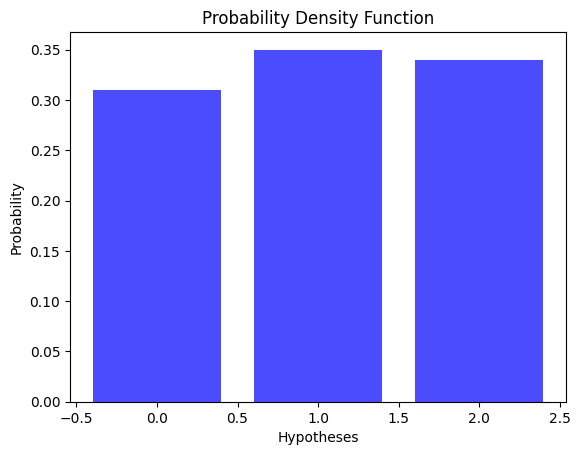

In [14]:
model_1=NBGaussian()
model_1.fit(X_train, y_train)
model_1.plot_pdf()

Nhận xét chart: `TODO`

#### Test

Label of X_test[10]:  2
Our histogram after update X_test[10]: 


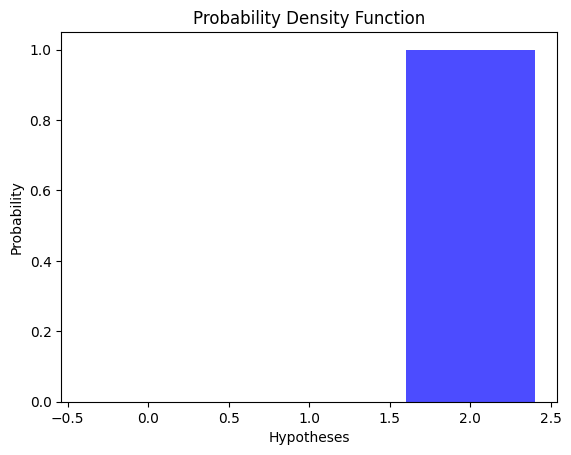

2

In [15]:
#label of y_test[10]
print('Label of X_test[10]: ', y_test[10])
#update model and show histogram with X_test[10]:

print('Our histogram after update X_test[10]: ')
model_1._predict(X_test[10],plot=True)


#### Đánh giá hiệu suất mô hình Gaussian Naive Bayes

In [16]:
pred=model_1.predict(X_test)
print('Accuracy of your Gaussian Naive Bayes model:', accuracy_score(y_test,pred))

Accuracy of your Gaussian Naive Bayes model: 0.96


## 2.3 Một số câu hỏi lí thuyết

*Đây là câu hỏi về lý thuyết có thể giúp các bạn buổi sung kiến thức cho các buổi phỏng vấn. Các bạn có thể tham khảo bất kì nguồn nào trừ ChatGPT và có thể thêm hình ảnh minh họa để có câu trả lời rõ ràng và dễ hiểu nhất. Và khi đã tham khảo phải liệt kê tài liệu tham khảo? Trường hợp phát hiện đạo văn bài làm sẽ nhận 0 điểm ngay lập tức.*

##### 1. Trường hợp sử dụng Gaussian Naive Bayes? Nêu chí tiết và cho 3 ứng dụng cụ thể (nêu rõ: input là gì? output là gì? mục tiêu sử dụng?)?

Câu trả lời:
`TODO`
- Trường hợp sử dụng Gaussian Naive Bayes là khi dữ liệu các thuộc tính đầu vào là liên tục và tuân theo phân phối chuẩn (Gaussian)
- Ứng dụng của Gaussian Naive Bayes:
    - Phân loại hoa với bộ dữ liệu Iris:
        - Input: 4 thuộc tính là Sepal Length, Sepal Width, Petal Length, Petal Width
        - Output: Setosa/ Versicolor/ Virginica
        - Mục tiêu sử dụng: Đoán loại hoa dựa trên 4 thuộc tính đầu vào 
    - Phân loại email(spam/ non-spam):
        - Input: 4 thuộc tính là tần suất suất hiện của từ khóa, độ dài email, tên miền người gửi, số link trong email 
        - Output: Spam/ non-spam
        - Mục tiêu sử dụng: Phân loại email là spam hay non-spam
    - Dự đoán có nên phê duyệt khoản vay cho khách hàng hay không:
        - Input: 5 thuộc tính là tuổi, thu nhập, nợ hiện tại, số tiền vay, thời hạn trả
        - Output: Cho/ không
        - Mục tiêu sử dụng: phân loại khách hàng nên cho vay hay không

##### 2. Có điều kiện bắt buộc nào của dữ liệu đầu vào khi sử dụng Gaussian Naive Bayes không?

Câu trả lời:
`TODO`
- Điều kiện bắt buộc của dữ liệu đầu vào khi sử dụng Gaussian Naive Bayes: 
  - Dữ liệu đầu vào phải là dữ liệu số chứ không phải dữ liệu phân loại hay văn bản
  - Dữ liệu của các thuộc tính đầu vào phải tuân theo phân phối chuẩn 

##### 3. Tại sao Naive Bayes thường được sử dụng trong các bài toán phân loại văn bản (Text Classification)?
Câu trả lời : `TODO`
- Naive Bayes thường được sử dụng trong các bài toán phân loại văn bản vì:
  - Văn bản thường được biểu diễn thành tần suất xuất hiện của từ trong từ vựng, từ đó thì số đặc trưng sẽ là rất nhiều nhưng với Naive Bayes thì tính toán dựa trên xác suất nên không tốn nhiều tài nguyên
  - Tốc độ xử lí của Naive Bayes rất nhanh vì các đặc trưng được giả định là độc lập, nâng cao hiệu suất trong các bài toán phân loại văn bản với dữ liệu lớn

## Tài liệu tham khảo

- https://www.geeksforgeeks.org/gaussian-naive-bayes/
- https://www.geeksforgeeks.org/naive-bayes-classifiers/
- https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/09_naive_bayes.pdf
- https://codinginfinite.com/naive-bayes-classification-numerical-example/#htoc-application-of-naive-bayes-classification
- https://www.geeksforgeeks.org/classification-of-text-documents-using-the-approach-of-naive-bayes/
- https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/
- https://www.geeksforgeeks.org/pruning-decision-trees/
- https://www.geeksforgeeks.org/overfitting-in-decision-tree-models/
- https://www.geeksforgeeks.org/bias-vs-variance-in-machine-learning/
- https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/